# Estimer la tendance centrale sur le cas de la poutre en flexion


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\} $
* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## Définition du modèle

In [1]:
import openturns as ot
import numpy as np

On commence par définir les lois marginales.

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

Les variables sont indépendantes, de telle sorte que l'on a pas besoin de spécifier une copule.

In [3]:
distcoll = [dist_E, dist_F, dist_L, dist_I]
X = ot.ComposedDistribution(distcoll)

Puis on définit le modèle.

In [4]:
g = ot.SymbolicFunction( ["E","F","L","I"],["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [5]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [6]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(['Y (cm)'])

## Par développement de Taylor

La classe `TaylorExpansionMoments` permet de réaliser le développement de Taylor. 

In [7]:
taylor = ot.TaylorExpansionMoments(Y)

La moyenne $E(Y)$ peut être estimée à l'ordre 1 avec `getMeanFirstOrder` ou bien à l'ordre 2 (c'est à dire en tenant compte des dérivées secondes) avec `getMeanSecondOrder`.

In [8]:
taylor.getMeanFirstOrder()[0]

12.339109534783237

In [9]:
taylor.getMeanSecondOrder()[0]

12.63262216382261

La variance peut être calculée à l'ordre 1 uniquement.

In [10]:
taylor.getCovariance()[0,0]

17.441552823530664

L'écart-type de la sortie peut être calculé en évaluant la racine carrée.

In [11]:
np.sqrt(taylor.getCovariance()[0,0])

4.176308516325232

Les facteurs d'importance $\eta_i$ peuvent être obtenus avec la méthode `getImportanceFactors` ou dessinés avec la méthode `drawImportanceFactors`.

In [12]:
importancefactors = taylor.getImportanceFactors()
importancefactors

class=PointWithDescription name=Unnamed dimension=4 description=[E,F,L,I] values=[0.153533,0.785641,0.0100685,0.050758]

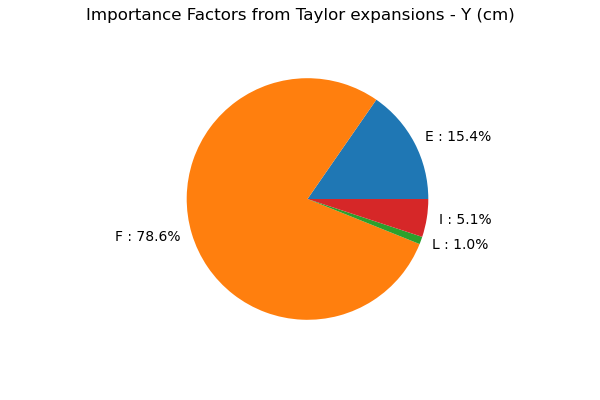

In [13]:
taylor.drawImportanceFactors()

On observe que la variabilité de la sortie $Y$ est principalement sensible à la variabilité de $F$ et, de manière moins importante par la variabilité de $E$. La variable $L$ pourrait être remplacée par une constante sans changer la variance de la sortie.

Une mise en garde s'impose au sujet des facteurs d'importance obtenus par la méthode `getImportanceFactors` : la dépendance éventuelle dans le vecteur aléatoire en entrée est ignorée. 

## Par Monte-Carlo simple avec un budget fixé

La manière la plus simple de faire une étude consiste à fixer le nombre de simulations à l'avance. En d'autres termes, on fixe $n$ et on génère un échantillon de la variable de sortie $Y$ de taille $n$. C'est la méthode "traditionnelle".

In [14]:
n = 10000

In [15]:
Ysample = Y.getSample(n)

La manière la plus simple d'observer la variabilité de la sortie consiste à tracer l'histogramme empirique.

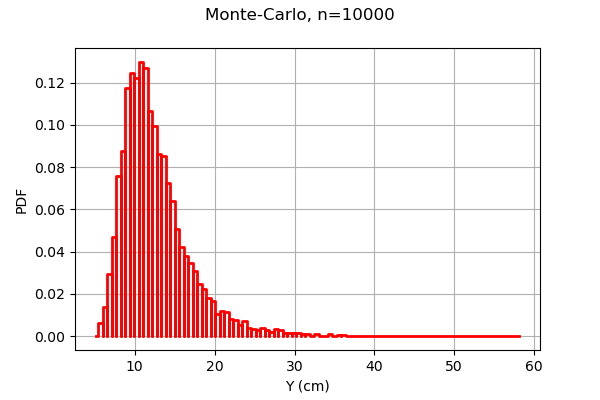

In [16]:
graph = ot.HistogramFactory().build(Ysample).drawPDF()
graph.setTitle("Monte-Carlo, n=%d" % (n))
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

Les méthodes associées à l'échantillon permettent de d'estimer la moyenne et la variance.

In [17]:
Ysample.computeMean()[0]

12.621487871354088

In [18]:
Ysample.computeVariance()[0]

18.674969862361277

In [20]:
Ysample.computeStandardDeviation()[0]

4.321454600289268

## Par Monte-Carlo simple avec un algorithme itératif

La méthode la plus performante consiste à utiliser la plus petite taille de l'échantillon possible assurant une précision déterminée. Pour cela, le plan d'expériences augmente de manière incrémentale, en mettant à jour la moyenne empirique. Pour améliorer la performance, les simulations sont réalisées avec une taille de bloc fixée par l'utilisateur. Lorsqu'on souhaite estimer la moyenne, c'est la méthode "moderne".

In [21]:
g.clearHistory()

In [22]:
algo = ot.ExpectationSimulationAlgorithm(Y)
algo.setMaximumOuterSampling(1000)
algo.setBlockSize(10)
algo.setMaximumCoefficientOfVariation(0.01)

In [23]:
algo.run()

In [24]:
result = algo.getResult()

In [25]:
outerSampleSize = result.getOuterSampling()
print("Number of iterations = %d" % (outerSampleSize))

Number of iterations = 118


In [26]:
expectation = result.getExpectationEstimate()
print("Mean = %f " % expectation[0])
blocksize = result.getBlockSize()
sampleSize = outerSampleSize * blocksize
print("Number of calls to G = %d" % (sampleSize))
cv = result.getCoefficientOfVariation()[0]
print("Coef. of var.=%.6f" % (cv))

Mean = 12.730356 
Number of calls to G = 1180
Coef. of var.=0.009962


The estimate of the mean has a known asymptotical gaussian distribution, which can be retrieved with the `getExpectationDistribution` method. 

Normal(mu = 12.7304, sigma = 0.126824)


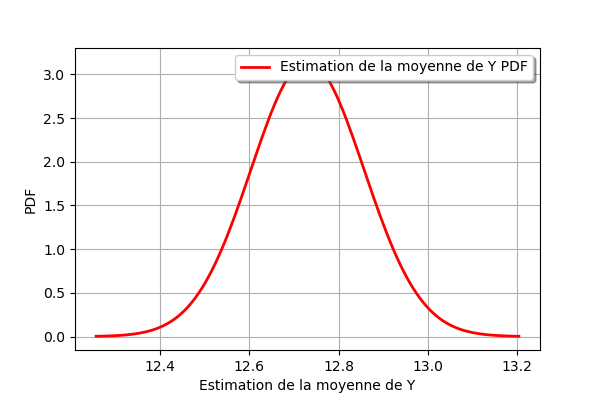

In [27]:
expectationDistribution = result.getExpectationDistribution()
expectationDistribution.setDescription(["Estimation de la moyenne de Y"])
print(expectationDistribution)
expectationDistribution.drawPDF()

In [28]:
Ysample = g.getOutputHistory()
sampleSize = Ysample.getSize()
print("Variance = %.4f" % (Ysample.computeVariance()[0]))

Variance = 18.9955


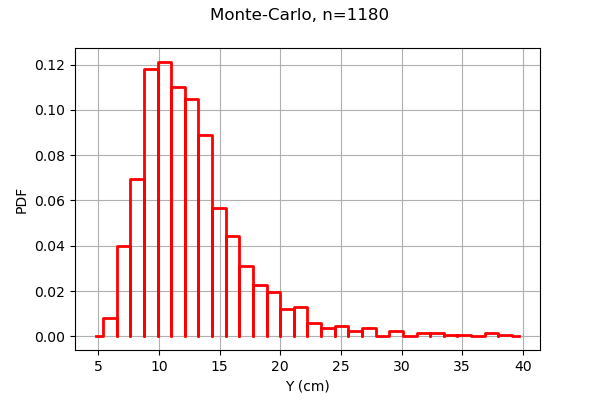

In [29]:
graph = ot.HistogramFactory().build(Ysample).drawPDF()
graph.setTitle("Monte-Carlo, n=%d" % (sampleSize))
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

## Synthèse des résultats

| Méthode | Moyenne | Variance |
|--|--|--|
| Taylor, 1er ordre | 12.33 | 17.44 |
| Taylor, 2ème ordre | 12.63 | - |
| Monte-Carlo simple, n=10000 | 12.62 | 18.67 |
| Monte-Carlo itératif, n=1180 | 12.73 | 19.05 |


## Exercice 1 : vérifications du développement de Taylor

L'objectif de cet exercice est de vérifier que les méthodes de la librairie coïncident avec les formules que nous avons présenté précédemment pour l'estimation de moments par développement de Taylor.
- Utiliser la méthode `getMean` de la variable `X` pour créer la variable `muX` contenant le point moyen $\mu$ du vecteur aléatoire en entrée.
- Evaluer le modèle `g` au point `muX` et comparer avec la valeur de retour de la méthode `getMeanFirstOrder`.
- Utiliser la méthode `gradient` de la fonction `g` pour créer la variable `gradient` contenant la valeur du gradient de la fonction $g$ au point `muX`. 
- Utiliser la méthode `getCovariance` de la variable `X` pour créer la variable `covX` contenant la matrice de covariance diagonale du vecteur aléatoire en entrée. 
- Avec une boucle `for`, calculer la variance de la sortie `Y` en utilisant le développement de Taylor à l'ordre 1.
Pour cela, vous pourrez vous aider du squelette suivant, dans lequel vous remplacerez les sections *TODO* par du code Python valide.
```
dim = len(distcoll)
v = 0.
for i in range(dim):
    v = v+TODO
```

- Comparer le résultat précédent avec la valeur de retour de la méthode `getCovariance`.

## Solution de l'exercice 1 : vérifications du développement de Taylor

In [30]:
muX = X.getMean()
muX

class=Point name=Unnamed dimension=4 values=[3.38065e+07,30000,255,397.5]

In [31]:
muY = g(muX)
muY[0]

12.339109534783237

In [32]:
taylor = ot.TaylorExpansionMoments(Y)
taylor.getMeanFirstOrder()[0]

12.339109534783237

On observe que la valeur de `muY` coïncide exactement avec $g(\mu)$.

In [33]:
gradient = g.gradient(muX)
gradient

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.64992e-07,0.000411303,0.145166,-0.0310418]

In [34]:
covX = X.getCovariance()
covX

class=CovarianceMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[2.0101e+13,0,0,0,0,8.1e+07,0,0,0,0,8.33333,0,0,0,0,918.75]

In [35]:
dim = len(distcoll)
v = 0.
for i in range(dim):
    v = v+gradient[i,0]**2 * covX[i,i]
v

17.441552823530664

In [36]:
taylor.getCovariance()[0,0]

17.441552823530664

## Exercice 2 : loi de la moyenne empirique

L'objectif de cet exercice est de vérifier la loi gaussienne de la moyenne empirique indiquée par le T.C.L.. Pour cela, nous considérons un échantillon Monte-Carlo simple de taille $n=100$. Cette faible taille d'échantillon est associée à une variabilité relativement importante de l'estimateur de la moyenne empirique. Puis nous allons réaliser $r$ estimations de la moyenne empirique. Nous allons ensuite comparer la distribution théorique et la distribution empirique. 
- Créer la variable `n=100`. 
- Générer un échantillon `Ysample` de taille `n` de la variable de sortie `Y`. Créer la variable `sigma` contenant l'écart-type empirique de cet échantillon. 
- Créer la variable `r=100`. 
- Créer la variable `meanSample` de type `Sample` de taille `r` en dimension 1.
- Avec une boucle `for` sur l'indice `k`, répéter l'expérience suivante `r` fois. 
  - Générer un échantillon `Ysample` de taille `n` de la variable de sortie `Y`.
  - Stocker dans `meanSample[k,0]` la moyenne empirique de `Ysample`.
Pour cela, vous pourrez vous inspirer du squelette suivant, dans lequel vous remplacer les sections *TODO* par du code Python valide.

```
r = 1000
meanSample = ot.Sample(r,1)
for k in range(r):
    Ysample = TODO
    meanSample[k,0] = Ysample.TODO
```

- Calculer `mu` la moyenne empirique de l'échantillon `meanSample`. 
- Créer la variable `M` de loi gaussienne de moyenne `mu` et d'écart-type `sigma/sqrt(n)`. 
- Dessiner l'histogramme empirique de l'échantillon `meanSample`. Dans le même graphique, dessiner la PDF de `M`.

- Optionnel : Écrire une fonction Python `compute_meanSample` prenant en argument `n` et renvoyant la variable `meanSample` construite précédément. À l'aide de cette fonction, dessiner sur le même graphique l'histogramme empirique des échantillons `meanSample` pour `n=100` et `n=400`. Quel est l'impact de `n` sur la distribution de la moyenne empirique ? Était-ce prévisible ?

## Solution de l'exercice 2 : loi de la moyenne empirique


In [38]:
n = 100
Ysample = Y.getSample(n)
sigma = Ysample.computeStandardDeviation()[0]
sigma

4.503003587455981

In [39]:
r = 1000
meanSample = ot.Sample(r,1)
for k in range(r):
    Ysample = Y.getSample(n)
    meanSample[k,0] = Ysample.computeMean()[0]

Nous pourrions utiliser pour `mu` la moyenne empirique de l'échantillon `Ysample`. Si nous le faisons, nous obtenons une distribution gaussienne centrée sur l'estimation à l'itération `j`. En conséquence, l'histogramme empirique des moyennes empiriques se trouve décalé par rapport à la loi gaussienne centrée sur une seule estimation. Dans le but de pouvoir comparer les variances de l'histogramme et de la loi gaussienne de manière graphique, il est plus commode d'utiliser pour `mu` la moyenne empirique de l'échantillon `meanSample`.

In [40]:
mu = meanSample.computeMean()[0]
mu

12.605479657018055

In [41]:
M = ot.Normal(mu,sigma/np.sqrt(n))
M

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[12.6055] sigma=class=Point name=Unnamed dimension=1 values=[0.4503] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

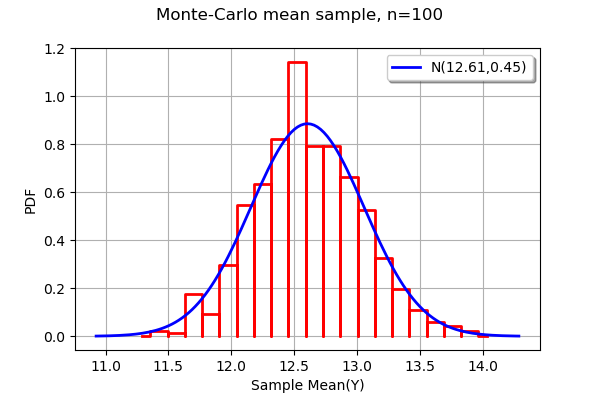

In [42]:
graph = ot.HistogramFactory().build(meanSample).drawPDF()
graph.setTitle("Monte-Carlo mean sample, n=%d" % (n))
graph.setXTitle("Sample Mean(Y)")
graph.setLegends([""])
gausspdf = M.drawPDF()
gausspdf.setColors(["blue"])
gausspdf.setLegends(["N(%.2f,%.2f)" % (mu,sigma/np.sqrt(n))])
graph.add(gausspdf)
graph

On observe que la distribution empirique de la moyenne empirique est proche de la distribution gaussienne.

Pour observer l'influence du paramètre $n$, on définit une fonction qui génère un échantillon de moyennes empiriques et retourne cet échantillon, ainsi que la loi gaussienne associée.

In [43]:
def resampleMean(n,r):
    meanSample = ot.Sample(r,1)
    for k in range(r):
        Ysample = Y.getSample(n)
        meanSample[k,0] = Ysample.computeMean()[0]
    return meanSample

In [44]:
meanSample100 = resampleMean(100,r)
meanSample400 = resampleMean(400,r)

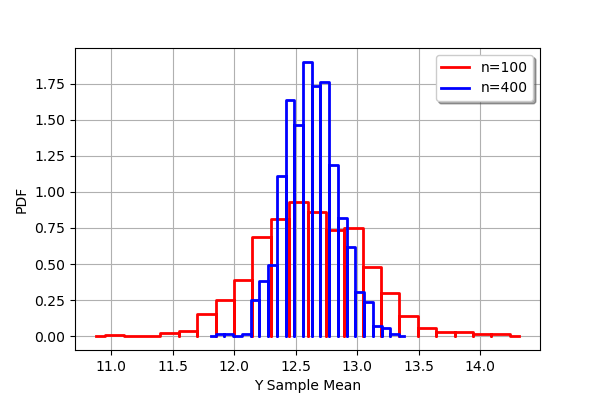

In [45]:
graph = ot.HistogramFactory().build(meanSample100).drawPDF()
graph.setTitle("")
graph.setXTitle("Y Sample Mean")
graph.setColors(["red"])
graph.setLegends(["n=100"])
graph400 = ot.HistogramFactory().build(meanSample400).drawPDF()
graph400.setColors(["blue"])
graph400.setLegends(["n=400"])
graph.add(graph400)
graph

On observe que la distribution de la moyenne empirique est plus resserrée avec $n=400$. C'est le résultat attendu, puisque la variance de l'estimateur de la moyenne empirique est divisé par 4 lorsqu'on passe d'un échantillon de taille $n=100$ à un échantillon de taille $n=400$.

## Exercice 3 : fixer une variable

On observe que le facteur d'importance associé à la variable $L$ est égal à 0.0100. Cela implique que, si on fixe cette variable à sa valeur moyenne, alors la variance va être peu modifiée. L'objectif de cet exercice est de le vérifier expérimentalement.
- Créer la variable `Lmean` contenant la valeur moyenne de la variable `dist_L` associée à $L$ grâce à la méthode `getMean`. 
- Créer la variable `L_fixed` contenant une distribution de type `Dirac` de paramètre `Lmean`. 
- Créer la distribution `Xfixed` associée au vecteur aléatoire dont les marginales sont `E`, `F`, `L_fixed`, `I` (la marginale $L$ est fixée).  
- Créer la variable `Yfixed` contenant le vecteur aléatoire de sortie associé. 
- Calculer la moyenne et la variance prédites par le développement de Taylor à l'ordre 1. 
- Comparer ces résultats avec les résultats du modèle précédent. 
- Calculer la perte de variance et la perte de variance prédite par le facteur d'importance de la variable `L`. Commenter. 

## Solution de l'exercice 3 : fixer une variable

Pour fixer la variable $L$ à sa valeur moyenne, nous utilisons la méthode `getMean`.

In [47]:
Lmean = dist_L.getMean()[0]
Lmean

255.0

La distribution de Dirac est une distribution qui permet de fixer une variable à une valeur constante, puisque sa densité de probabilité est infinie en un point, et nulle ailleurs.

In [48]:
L_fixed = ot.Dirac(Lmean)
distcollfixed = [dist_E, dist_F, L_fixed, dist_I]
Xfixed = ot.ComposedDistribution(distcollfixed)

In [49]:
XRVfixed = ot.RandomVector(Xfixed)
Yfixed = ot.CompositeRandomVector(g, XRVfixed)

In [50]:
taylorfixed = ot.TaylorExpansionMoments(Yfixed)

In [51]:
taylorfixed.getMeanFirstOrder()[0]

12.339109534783237

In [52]:
taylorfixed.getCovariance()[0,0]

17.265943107139222

La table suivante compare le développement de Taylor lorsque L suit la loi uniforme et lorsque L est fixé à sa valeur moyenne. On observe que la moyenne est inchangée, ce qui est le résultat attendu puisque la moyenne estimée par le développement de Taylor ne dépend pas de la variance du vecteur d'entrée. On observe que la variance a été un peu réduite. 

| Méthode | Moyenne | Variance |
|--|--|--|
| Taylor, 1er ordre (E,F,L,I) | 12.33 | 17.44 |
| Taylor, 1er ordre (E,F,muL,I) | 12.33 | 17.28 |

Le calcul suivant évalue la perte de variance entre le modèle inconditionnel et le modèle conditionné. 

In [53]:
taylor.getCovariance()[0,0] - taylorfixed.getCovariance()[0,0]

0.17560971639144185

Le calcul suivant évalue la perte de variance prédite par le facteur d'importance de la variable $L$. On observe que la perte de variance est supérieure à celle prédite. Cet écart est dû au fait que le modèle $g$ n'est pas parfaitement linéaire dans notre cas particulier, de telle sorte que les dérivées secondes ont une influence significative. Toutefois, le résultat reste pertinent, dans la mesure où le décalage reste modéré. 

In [54]:
importancefactors[2] * taylor.getCovariance()[0,0]

0.1756097163914402

## Exercice 4 : développement de Taylor avec dépendance

On suppose que le problème est associé à une structure de dépendance gaussienne. Le coefficient de corrélation de Spearman (sur les rangs) est entre la longueur $L$ et le moment d'inertie $I$ est égal à 
$$
\rho_{rg}(L,I) = -0.2.
$$
L'objectif de cet exercice est d'observer comment cette dépendance peut affecter les moments estimés par développement de Taylor.

- Définir la copule associée à cette nouvelle structure de dépendance. Pour cela, créer la matrice de corrélation sur les rangs `smatrix` avec la classe `CorrelationMatrix`. 
- Créer la variable `matrix` contenant la matrice de corrélation de Pearson calculée grâce à la fonction `GetCorrelationFromSpearmanCorrelation` de `NormalCopula` et de la matrice `smatrix`.
- Créer la variable `copula` contenant la copule gaussienne grâce à la classe `NormalCopula`.
- Créer la variable `Xgauss` contenant le vecteur aléatoire en entrée du modèle, puis le vecteur aléatoire de sortie correspondant `Ygauss`.
- Utiliser la classe `TaylorExpansionMoments` pour calculer l'approximation de la moyenne à l'ordre 1 et à l'ordre 2, l'écart-type et les facteurs d'importance de la sortie `Y`.
- Comparer les résultats numériques avec ceux sans dépendance à l'aide d'un tableau de la forme

`| titre | titre | ... |`

`|--|--|--|`

`| donnée | donnée | ... |`

Comment expliquer les différences ?

## Solution de l'exercice 4 : développement de Taylor avec dépendance

In [55]:
dim = len(distcoll)
smatrix = ot.CorrelationMatrix(dim)
smatrix[2, 3] = -0.2
smatrix

class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.2,0,0,-0.2,1]

In [56]:
matrix = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(smatrix)
matrix

class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.209057,0,0,-0.209057,1]

In [57]:
copula = ot.NormalCopula(matrix)
copula

class=NormalCopula name=NormalCopula dimension=4 correlation=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.209057,0,0,-0.209057,1]

In [58]:
Xgauss = ot.ComposedDistribution(distcoll,copula)
XRVgauss = ot.RandomVector(Xgauss)
Ygauss = ot.CompositeRandomVector(g, XRVgauss)
Ygauss.setDescription(['Y, gaussien (cm)'])

In [59]:
taylor = ot.TaylorExpansionMoments(Ygauss)
print("Taylor, Mean, First : %.4f" % (taylor.getMeanFirstOrder()[0]))
print("Taylor, Mean, Second : %.4f" % (taylor.getMeanSecondOrder()[0]))
print("Taylor, Variance : %.4f" % (taylor.getCovariance()[0,0]))
print("Taylor, St.Dev : %.4f" % (np.sqrt(taylor.getCovariance()[0,0])))

Taylor, Mean, First : 12.3391
Taylor, Mean, Second : 12.6390
Taylor, Variance : 17.5997
Taylor, St.Dev : 4.1952


In [60]:
taylor.getImportanceFactors()

class=PointWithDescription name=Unnamed dimension=4 description=[E,F,L,I] values=[0.152153,0.778582,0.0144704,0.0547944]

La table suivante permet de comparer les résultats numériques sans et avec dépendance.

| Moment | Sans dépendance | Avec dépendance |
|--|--|--|
| Moyenne, 1er ordre | 12.34 | 12.34 |
| Moyenne, 2nd ordre | 12.63 | 12.64 |
|Variance|17.44|17.60|
|Ecart-type|4.176|4.195|
|$\eta_E$|0.1535|0.1535|
|$\eta_F$|0.7856|0.7856|
|$\eta_L$|0.0100|0.0100|
|$\eta_I$|0.0508|0.0508|

Les différences apparaissent dans les estimateurs suivants :
- l'estimation de la moyenne au second ordre, car la dépendance intervient en combinaison avec la matrice Hessienne,
- la variance, car la dépendance intervient en combinaison avec les dérivées premières.
- l'écart-type, car il dépend de la variance.

Les résultats suivants sont identiques :
- la moyenne au premier ordre, car elle ne dépend que de la fonction $g$ au point $\mu$,
- les facteurs d'importance, car ils ne prennent pas en compte la dépendance.
